# metabolite2vec:
In this notebook, the word2vec algorithm and skipgram model for embedding words in a feature space that represents their context was adapted to embed metabolites. The code here was initially adapted from the [TensorFlow word2vec tutorial](https://www.tensorflow.org/tutorials/representation/word2vec). [Arxiv paper](https://arxiv.org/pdf/1310.4546.pdf).

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Step 1a: Load the Data (ModelSEED)
ModelSEED contains a large database of metabolites and metabolic reactions. This databases consists of 27,694 metabolites and 34,711 reactions, which can be downloaded from the ModelSEED github. Metabolite and reaction details can be viewed on the model seed website (modelseed.org).

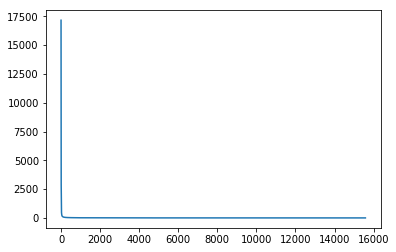

In [6]:
# Load Data (ModelSEED database reactions, modelseed.org)
# The modelseed reactions metadata has a column corresponding to the metabolites used by a reaciton, 
# this column will be the entirety of our data.

import csv
file_name = './reactions.tsv'
data_c = []
with open(file_name) as tsvfile:
    reader = csv.DictReader(tsvfile,dialect='excel-tab')
    for row in reader:
        tmp = row['compound_ids']
        data_c.append(tmp.split(';'))
# remove reactions with only 1 metabolite
indexes = []
for i in range(len(data_c)):
    if len(data_c[i]) <= 1:
        indexes.append(i)
for index in sorted(indexes, reverse=True):
    del data_c[index]
    
# Load metabolite names
# Metabolites names will be used for a dictionary that converts metabolite ids to names for data visualization
file_name = './compounds.tsv'
name_dictionary = dict()
with open(file_name) as tsvfile:
    reader = csv.DictReader(tsvfile,dialect='excel-tab')
    for row in reader:
        tmp1 = row['id']
        tmp2 = row['abbreviation']
        name_dictionary[tmp1]=tmp2
        
# Deifne other dictionarys for data manipulation
# count, dictionary, reverse_dictionary, data, sort_dicitonary

# count: the number of times each metabolite appears in any reaction
from collections import Counter
from itertools import chain
count = Counter(chain.from_iterable(data_c))

# dictionary: to convert metabolite ids to a unique index
dictionary = dict()
for word in count:
    dictionary[word] = len(dictionary)
# reverse_dicitonary: to convert metabolite index back to ids
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

# data: convert metabolite id data to index data
data = []
for rxn in data_c:
    data.append([dictionary[cmp] for cmp in rxn])

# vocabulary size: the total number of unique metabolites
vocabulary_size = len(count)

# sort dictionary: dictionary to get metabolite index sorted by count
import operator
sorted_count = sorted(count.items(), key=operator.itemgetter(1))
sorted_count.reverse()
sort_dictionary = dict()
for x in sorted_count:
    tmp = x[0]
    sort_dictionary[len(sort_dictionary)] = dictionary[tmp]
    
# Plot data
# plot the frequency of metabolite counts in reactions to get an idea of what the data looks like
import matplotlib.pyplot as plt
import numpy as np

sorted_count_a = np.array(sorted_count)
plt.plot(sorted_count_a[:,1].astype(float))
plt.show()

### Step 1a_2: Load the Data (ModelSEED)
This will load the same data as step 1a but will only consider metabolites to be in the same context if they are on the same side of a reaction

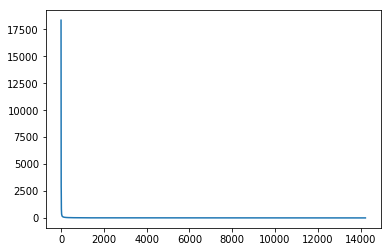

In [19]:
# Load Data (ModelSEED database reactions, modelseed.org)
# The modelseed reactions metadata has a column corresponding to the metabolites used by a reaciton, 
# this column will be the entirety of our data.

import csv
import re
file_name = './reactions.tsv'
data_c = []
with open(file_name) as tsvfile:
    reader = csv.DictReader(tsvfile,dialect='excel-tab')
    for row in reader:
        tmp = row['equation']
        tmpS = tmp.split('=')
        for s in range(len(tmpS)):
            tmp = tmpS[s]
            index = [m.start() for m in re.finditer('cpd\d\d\d\d\d', tmp)]
            lst = []
            for j in range(len(index)):
                lst.append(tmp[index[j]:index[j]+8])
            data_c.append(lst)
        
# remove reactions with only 1 metabolite
indexes = []
for i in range(len(data_c)):
    if len(data_c[i]) <= 1:
        indexes.append(i)
for index in sorted(indexes, reverse=True):
    del data_c[index]
    
# Load metabolite names
# Metabolites names will be used for a dictionary that converts metabolite ids to names for data visualization
file_name = './compounds.tsv'
name_dictionary = dict()
with open(file_name) as tsvfile:
    reader = csv.DictReader(tsvfile,dialect='excel-tab')
    for row in reader:
        tmp1 = row['id']
        tmp2 = row['abbreviation']
        name_dictionary[tmp1]=tmp2
        
# Deifne other dictionarys for data manipulation
# count, dictionary, reverse_dictionary, data, sort_dicitonary

# count: the number of times each metabolite appears in any reaction
from collections import Counter
from itertools import chain
count = Counter(chain.from_iterable(data_c))

# dictionary: to convert metabolite ids to a unique index
dictionary = dict()
for word in count:
    dictionary[word] = len(dictionary)
# reverse_dicitonary: to convert metabolite index back to ids
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

# data: convert metabolite id data to index data
data = []
for rxn in data_c:
    data.append([dictionary[cmp] for cmp in rxn])

# vocabulary size: the total number of unique metabolites
vocabulary_size = len(count)

# sort dictionary: dictionary to get metabolite index sorted by count
import operator
sorted_count = sorted(count.items(), key=operator.itemgetter(1))
sorted_count.reverse()
sort_dictionary = dict()
for x in sorted_count:
    tmp = x[0]
    sort_dictionary[len(sort_dictionary)] = dictionary[tmp]
    
# Plot data
# plot the frequency of metabolite counts in reactions to get an idea of what the data looks like
import matplotlib.pyplot as plt
import numpy as np

sorted_count_a = np.array(sorted_count)
plt.plot(sorted_count_a[:,1].astype(float))
plt.show()

### Step 1b: Load the Data (KEGG)
KEGG is an alternative database of reactions and metabolties. Using this load code, sentences will be KEGG reactions and words will be KEGG metabolites.

https://www.genome.jp/kegg/

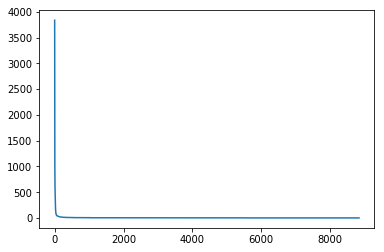

In [30]:
# Load KEGG Reactions JSON file
import json
import re
with open('./KEGG_R_db_27jun18.json') as json_file:
    js = json.load(json_file)
data_c = []
for i in range(len(js)):
    # Exctract reaction metabolites from json data
    tmp = js[i]['EQUATION'][0]
    index = [m.start() for m in re.finditer('\D\d\d\d\d\d', tmp)]
    lst = []
    for j in range(len(index)):
        lst.append(tmp[index[j]:index[j]+6])
    data_c.append(lst)
    
# remove reactions with only 1 metabolite
indexes = []
for i in range(len(data_c)):
    if len(data_c[i]) <= 1:
        indexes.append(i)
for index in sorted(indexes, reverse=True):
    del data_c[index]

# Load metabolite names
# Metabolites names will be used for a dictionary that converts metabolite ids to names for data visualization
with open('./KEGG_C_db_27jun18.json') as json_file:
    js = json.load(json_file)
name_dictionary = dict()
for key in js.keys():
    tmp1 = key
    tmp2 = js[key]['NAME']
    name_dictionary[tmp1]=tmp2

# Deifne other dictionarys for data manipulation
# count, dictionary, reverse_dictionary, data, sort_dicitonary

# count: the number of times each metabolite appears in any reaction
from collections import Counter
from itertools import chain
count = Counter(chain.from_iterable(data_c))

# dictionary: to convert metabolite ids to a unique index
dictionary = dict()
for word in count:
    dictionary[word] = len(dictionary)
# reverse_dicitonary: to convert metabolite index back to ids
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

# data: convert metabolite id data to index data
data = []
for rxn in data_c:
    data.append([dictionary[cmp] for cmp in rxn])

# vocabulary size: the total number of unique metabolites
vocabulary_size = len(count)

# sort dictionary: dictionary to get metabolite index sorted by count
import operator
sorted_count = sorted(count.items(), key=operator.itemgetter(1))
sorted_count.reverse()
sort_dictionary = dict()
for x in sorted_count:
    tmp = x[0]
    sort_dictionary[len(sort_dictionary)] = dictionary[tmp]
    
# Plot data
# plot the frequency of metabolite counts in reactions to get an idea of what the data looks like
import matplotlib.pyplot as plt
import numpy as np

sorted_count_a = np.array(sorted_count)
plt.plot(sorted_count_a[:,1].astype(float))
plt.show()

### Step 1b_2: Load the Data (KEGG)
This will load the same data as step 1b but will only consider metabolites to be in the same context if they are on the same side of a reaction

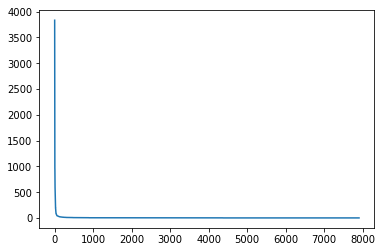

In [38]:
# Load KEGG Reactions JSON file
import json
with open('./KEGG_R_db_27jun18.json') as json_file:
    js1 = json.load(json_file)
import re
data_c = []
for i in range(len(js1)):
    # Exctract reaction metabolites from json data
    tmp = js1[i]['EQUATION'][0]
    tmpS = tmp.split('=')
    for s in range(len(tmpS)):
        tmp = tmpS[s]
        index = [m.start() for m in re.finditer('\D\d\d\d\d\d', tmp)]
        lst = []
        for j in range(len(index)):
            lst.append(tmp[index[j]:index[j]+6])
        data_c.append(lst)
    
# remove reactions with only 1 metabolite
indexes = []
for i in range(len(data_c)):
    if len(data_c[i]) <= 1:
        indexes.append(i)
for index in sorted(indexes, reverse=True):
    del data_c[index]

# Load metabolite names
# Metabolites names will be used for a dictionary that converts metabolite ids to names for data visualization
with open('./KEGG_C_db_27jun18.json') as json_file:
    js = json.load(json_file)
name_dictionary = dict()
for key in js.keys():
    tmp1 = key
    tmp2 = js[key]['NAME']
    name_dictionary[tmp1]=tmp2

# Deifne other dictionarys for data manipulation
# count, dictionary, reverse_dictionary, data, sort_dicitonary

# count: the number of times each metabolite appears in any reaction
from collections import Counter
from itertools import chain
count = Counter(chain.from_iterable(data_c))

# dictionary: to convert metabolite ids to a unique index
dictionary = dict()
for word in count:
    dictionary[word] = len(dictionary)
# reverse_dicitonary: to convert metabolite index back to ids
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

# data: convert metabolite id data to index data
data = []
for rxn in data_c:
    data.append([dictionary[cmp] for cmp in rxn])

# vocabulary size: the total number of unique metabolites
vocabulary_size = len(count)

# sort dictionary: dictionary to get metabolite index sorted by count
import operator
sorted_count = sorted(count.items(), key=operator.itemgetter(1))
sorted_count.reverse()
sort_dictionary = dict()
for x in sorted_count:
    tmp = x[0]
    sort_dictionary[len(sort_dictionary)] = dictionary[tmp]
    
# Plot data
# plot the frequency of metabolite counts in reactions to get an idea of what the data looks like
import matplotlib.pyplot as plt
import numpy as np

sorted_count_a = np.array(sorted_count)
plt.plot(sorted_count_a[:,1].astype(float))
plt.show()

### Step 1c: Load the Data (KEGG reaction classes)
KEGG contains additional metadata related to reactions. One form of metadata stored in KEGG are reaciton classes and reaction pairs. Reaction classes and pairs represent chemical structure transformation patterns, and are a predifined way of annotating "metabolite phrases".

for additional information on KEGG reaction classes:
https://www.genome.jp/kegg/reaction/

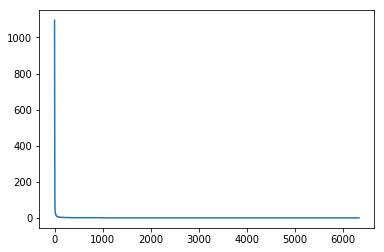

In [22]:
# Load KEGG Reactions JSON file
import json
with open('./KEGG_R_db_27jun18.json') as json_file:
    js = json.load(json_file)
import re
data_c = []
for i in range(len(js)):
    d1 = js[i]
    if 'RCLASS' in d1.keys():
        # Exctract reaction classes from json data
        k1 = d1['RCLASS']
        lst = []
        for k in range(len(k1)):
            tmp = k1[k]
            # exctract compound pairs
            index = [m.start() for m in re.finditer('\D\d\d\d\d\d_\D\d\d\d\d\d', tmp)]
            for j in range(len(index)):
                lst.append(tmp[index[j]:index[j]+13])
        data_c.append(lst)
        
# remove reactions with only 1 metabolite pair
indexes = []
for i in range(len(data_c)):
    if len(data_c[i]) <= 1:
        indexes.append(i)
for index in sorted(indexes, reverse=True):
    del data_c[index]

# Load metabolite names
# Metabolites names will be used for a dictionary that converts metabolite ids to names for data visualization
with open('./KEGG_C_db_27jun18.json') as json_file:
    js = json.load(json_file)
name_dictionary = dict()
for key in js.keys():
    tmp1 = key
    tmp2 = js[key]['NAME']
    name_dictionary[tmp1]=tmp2

# Deifne other dictionarys for data manipulation
# count, dictionary, reverse_dictionary, data, sort_dicitonary

# count: the number of times each metabolite appears in any reaction
from collections import Counter
from itertools import chain
count = Counter(chain.from_iterable(data_c))

# dictionary: to convert metabolite ids to a unique index
dictionary = dict()
for word in count:
    dictionary[word] = len(dictionary)
# reverse_dicitonary: to convert metabolite index back to ids
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

# data: convert metabolite id data to index data
data = []
for rxn in data_c:
    data.append([dictionary[cmp] for cmp in rxn])

# vocabulary size: the total number of unique metabolites
vocabulary_size = len(count)

# sort dictionary: dictionary to get metabolite index sorted by count
import operator
sorted_count = sorted(count.items(), key=operator.itemgetter(1))
sorted_count.reverse()
sort_dictionary = dict()
for x in sorted_count:
    tmp = x[0]
    sort_dictionary[len(sort_dictionary)] = dictionary[tmp]
    
# Plot data
# plot the frequency of metabolite counts in reactions to get an idea of what the data looks like
import matplotlib.pyplot as plt
import numpy as np

sorted_count_a = np.array(sorted_count)
plt.plot(sorted_count_a[:,1].astype(float))
plt.show()


In [21]:
vocabulary_size

6331

### Step 2: Define how to Sample the Data
The data is sampled by defining metabolites as words and metabolites that are products or reactants of the same reaction as context metabolites. To generate a single sample for a minibatch first a reaction is chosen at random, then 1 center and 1 context metabolite from that reaction are chosen at random as the input and label of the sampled data point. The model thus adjusts metabolite embeddings such that metabolites dot products predict metabolites that appear in the same context in metabolic reactions.

In [20]:
# Define function for generating a training batch
# Context is defined as all of the metabolites in a given reaction
# A batch is sampled by first randomly choosing a reaction and then randomly choosing 1 center and 1 neighbor metabolite
from random import randint
import numpy as np

def generate_batch(batch_size):
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        #choose random reaction
        tmp = data[randint(0,len(data)-1)]
        #choose random metabolite
        batch[i] = tmp[randint(0,len(tmp)-1)]
        labels[i] = tmp[randint(0,len(tmp)-1)]
    
    return batch, labels


In [21]:
# visualize a batch
batch_size = 10
batch, labels = generate_batch(batch_size)
for i in range(batch_size):
    if reverse_dictionary[batch[i]] in name_dictionary.keys():
        print(batch[i], name_dictionary[reverse_dictionary[batch[i]]], '->', labels[i, 0],
            name_dictionary[reverse_dictionary[labels[i, 0]]])
    else:
        print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
            reverse_dictionary[labels[i, 0]])

3 h -> 3 h
2 pi -> 2 pi
9 o2 -> 9 o2
0 h2o -> 0 h2o
3 h -> 3 h
9220 mannobiose -> 3 h
4633 1,4-alpha-D-Glucooligosaccharide -> 147 amet
424 dhap -> 424 dhap
92 atp -> 3 h
8 pyr -> 8 pyr


### Step 3: Skip-gram Model
A skip-gram model with noise contrastive estimation (NCE) loss was used for our method. For a quick introduction to the skip-gram model and how it translates over to a neural network see (http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

In [22]:
# Build and train a skip-gram model.

import tensorflow as tf
import math

# Hyperparameters:
batch_size = 64 # Size of mini-batch
embedding_size = 128  # Dimension of the embedding vector.
num_sampled = 64  # Number of negative examples to sample.
lr = 1 # Learning rate for Stochastic Gradient Descent

# Validation set: A set of metabolites to monitor the progress of the algorithm
# The metabolites chosen here do not impact the calculations
valid_size = 10  # number of validation examples to show
valid_examples_1 = range(valid_size)
valid_examples = [sort_dictionary[ex] for ex in valid_examples_1] #chooes the metabolites with the highest counts

graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [vocabulary_size, embedding_size],
                stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)
    
    # Construct the SGD optimizer
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()


In [23]:
# Begin training.

num_steps = 100001

with tf.Session(graph=graph) as session:

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val
    

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 3  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                if valid_word in name_dictionary.keys():
                    log_str = 'Nearest to %s:' % name_dictionary[valid_word]
                else:
                    log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    if reverse_dictionary[nearest[k]] in name_dictionary.keys():
                        close_word = name_dictionary[reverse_dictionary[nearest[k]]]
                    else:
                        close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  237.69456481933594
Nearest to h: Monogalactosyldiacylglycerol (1-(9Z,12Z)-octadecadienoyl,2-(7Z,10Z,13Z)-hexadecatrienoyl, 18:2(9Z,12Z)/16:3(7Z,10Z,13Z)), 3sala, beta-D-Galactoside,
Nearest to h2o: O-Methylandrocymbine, cis-4-(1'-Hydroxynaphth-2'-yl)-2-oxobut-3-enoate, arsenb,
Nearest to nadp: Testololactone, tmrs2eACP, RNA terminal-2',3'-cyclic-phosphate,
Nearest to nadph: 5alpha-Cholestan-3-one, (+)-(1R,2S)-cis-3,4-Dihydroxy-3,4-dihyd, ent-cassa-12,15-diene,
Nearest to o2: 4-NO-2,6-dinitrotoluene, Poly-beta-hydroxybutyrate, (Z)-3-Peroxyaminoacrylate,
Nearest to atp: C-glucosyl-2-hydroxyflavanone, hpmtria, LalaDgluMdap,
Nearest to pi: (S)-3-Sulfolactate, trans-2-Enoyl-OPC4-CoA, CPLX0-7605,
Nearest to nad: Pelargonidin 3-O-rutinoside, Germacrene B, 5-Phosphomononucleotides,
Nearest to nadh: 4-oxahomoadamantan-5-one, N-ACETYL-BETA-D-GLUCOSAMINYL-16-ETCETERA, Progesterone,
Nearest to adp: 3-HYDROXY-DOCOSAPENTAENOYL-ACP, PROTEIN-PII2, (6Z,9Z,12Z,15Z,

### Step 4: Analyze/Visualize the Data
We can analyze the embeddings we have created by visualizing them in a low dimensional space and exploring which metabolites end up close to each other in the embeded space.

##### Visualize the data using tSNE

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

x = low_dim_embs[:,0]
y = low_dim_embs[:,1]

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(x,
                     y)
ax.grid(color='white', linestyle='solid')

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

##### Analyze the data

In [26]:
# Explore Metabolite Similarity
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

cos_sim = 1-pairwise_distances(final_embeddings, metric="cosine")

In [27]:
# What are the closest metabolites
topN = 50
cos_sim_1 = cos_sim - np.triu(cos_sim) # subtract upper triangel and diagonal
cos_sim_1d = cos_sim_1.flatten()
idx_1d = cos_sim_1d.argsort()[-topN:]
x_idx, y_idx = np.unravel_index(idx_1d, cos_sim.shape)


In [28]:
# cosine similarity vs number of times reactions co-occur
# count co-occurences
met_co = np.zeros_like(cos_sim)
for inds in data:
    for x in inds:
        for y in inds:
            met_co[x,y]=met_co[x,y]+1


In [29]:
# correlation of top n
from scipy.stats import spearmanr
rho, pval = spearmanr(met_co[x_idx,y_idx],cos_sim[x_idx,y_idx])
print(rho)
print(pval)

0.2917257155399352
0.039822296904386205


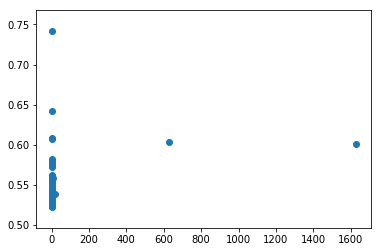

In [30]:
plt.scatter(met_co[x_idx,y_idx],cos_sim[x_idx,y_idx])
plt.show()

In [31]:
# normalized co-occurence counts (only calculate for top n to save time)
met_co_norm = np.zeros_like(met_co)
for x,y in zip(x_idx, y_idx):
    met_co_norm[x,y] = 2*met_co[x,y]/(met_co[x,x]+met_co[y,y])

In [32]:
rho, pval = spearmanr(met_co_norm[x_idx,y_idx],cos_sim[x_idx,y_idx])
print(rho)
print(pval)

0.2972595577569432
0.03604448374139763


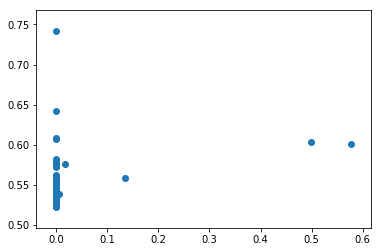

In [33]:
plt.scatter(met_co_norm[x_idx,y_idx],cos_sim[x_idx,y_idx])
plt.show()

In [34]:
# print most similar metabolites along with metabolite co-occurence
for x,y in zip(x_idx, y_idx):
    if reverse_dictionary[x] in name_dictionary.keys():
        print(name_dictionary[reverse_dictionary[x]])
    else:
        print(reverse_dictionary[x])
    print([reverse_dictionary[x]])
    if reverse_dictionary[y] in name_dictionary.keys():
        print(name_dictionary[reverse_dictionary[y]])
    else:
        print(reverse_dictionary[y])
    print([reverse_dictionary[y]])
    print("Cosine Similarity: {}".format(cos_sim[x][y]))
    print("Metabolite Co-occurrence: {}".format(met_co[x][y]))
    print("Normalized Co-occurence: {}".format(met_co_norm[x][y]))
    print('')

benzenecarboxylic acid beta-D-glucose ester
['cpd23502']
23camp
['cpd01570']
Cosine Similarity: 0.5225445628166199
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

Phosphorylated-receptor-proteins
['cpd27872']
Inositol 3,4-bisphosphate
['cpd02513']
Cosine Similarity: 0.5233538746833801
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

1,2-Diacyl-sn-glycerol (1,2-di-(9Z)-octadecenoyl, 18:1(9Z)/18:1(9Z))
['cpd30074']
1,2-Diacyl-sn-glycerol (1-(11Z)-octadecenoyl,2-(9Z)-octadecenoyl, 18:1(11Z)/18:1(9Z))
['cpd30068']
Cosine Similarity: 0.5237115621566772
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

(R)-1-(threo-4-Hydroxy-L-3,6-diaminohexanoic acid)-6-[L-2-(2-amino-1,4,5,6-tetrahydro-4-pyrimidinyl)glycine]viomycin
['cpd26999']
dhp23cp
['cpd15850']
Cosine Similarity: 0.5238682627677917
Metabolite Co-occurrence: 0.0
Normalized Co-occurence: 0.0

EG12385-MONOMER
['cpd29239']
1,2-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphocholine
['cpd24367']
Cosine Similari

In [36]:
# Find closest metabolites to a particular metabolite
met = 'cpd00005'
topN = 10
cos_sim_met = cos_sim[dictionary[met]][:]
ids = cos_sim_met.argsort()[-topN:]

for x in ids:
    if reverse_dictionary[x] in name_dictionary.keys():
        print(name_dictionary[reverse_dictionary[x]])
    else:
        print(reverse_dictionary[x])
    print("Cosine Similarity: {}".format(cos_sim[x][dictionary[met]]))
    print("Metabolite Co-occurrence: {}".format(met_co[x][dictionary[met]]))
    print('')

2-Prime-Ribonucleoside-Monophosphates
Cosine Similarity: 0.41522276401519775
Metabolite Co-occurrence: 0.0

7alpha-Hydroxycholest-4-en-3-one
Cosine Similarity: 0.4158322811126709
Metabolite Co-occurrence: 4.0

N4-{N-acetyl-beta-D-glucosaminyl-(1,2)-alpha-D-mannosyl-(1,3)-[N-acetyl-beta-D-glucosaminyl-(1,2)-alpha-D-mannosyl-(1,6)]-beta-D-mannosyl-(1,4)-N-acetyl-beta-D-glucosaminyl-(1,4)-[alpha-L-fucosyl-(1,6)]-N-acetyl-beta-D-glucosaminyl}asparagine
Cosine Similarity: 0.4170662760734558
Metabolite Co-occurrence: 0.0

Naphthyl-2-methyl-succinic acid
Cosine Similarity: 0.42445802688598633
Metabolite Co-occurrence: 0.0

4-(2-Amino-3-hydroxyphenyl)-2,4-dioxobutanoate
Cosine Similarity: 0.4264063835144043
Metabolite Co-occurrence: 0.0

a cis,cis-delta21,39-3-oxo-C58:2-[acp]
Cosine Similarity: 0.42958366870880127
Metabolite Co-occurrence: 4.0

actACP
Cosine Similarity: 0.4398742914199829
Metabolite Co-occurrence: 18.0

NADH-P-OR-NOP
Cosine Similarity: 0.4525600075721741
Metabolite Co-occurren

### Comments
In this notebook we have implemented the skip-gram model from word2vec towards embedding metabolites by using metabolic reactions as the context. Metabolites that co-occur often with other metabolites such as the cofactors nadph and nadp or atp and adp have very high similarity in this embedding space. These metabolites can be thought of as "phrases" that co-occur often and thus are always found in similar context. Additionally, there are some metabolites that have high similarity in the embedding space, but low co-occurence. One example is, alpha-D-glucose, glc-D-B and glc-D. In the modelSEED database these metabolites are alpha-D-Glucose, beta-D-Glucose and D-Glucose, respectively. These metabolites have similar structure and participate in similar reacitons. For example, in the modelSEED database rxn00007 hydrolyzes Trehalose to 2 D-Glucose, while rxn15002 hydrolyzes Trehalose to 2 alpha-D-Glucose.

#### Future Directions:
* Embed metabolite "phrases" by reassigning highly co-occurring metabolites to a unique "phrase" IDs
* Utilize more sophisticated reaction structures such as KEGG reaction classes to embed different components of reactions